In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn

# To Show Image (Null Value and Histo)
import plotly.express as px

# To use plusieurs Plots In The Same figure
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# 
from sklearn.preprocessing import OneHotEncoder,MinMaxScaler

# 
from sklearn.model_selection import train_test_split

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

from sklearn.linear_model import SGDClassifier

#
from joblib import Parallel,delayed
from itertools import product

#
from sklearn.model_selection import GridSearchCV

# 
from sklearn.feature_selection import SequentialFeatureSelector

#from sklearn.neighbors import KNeighborsClassifier
#from sklearn.svm import SVC
#from sklearn.tree import DecisionTreeClassifier
#from xgboost import XGBClassifier
#from catboost import CatBoostClassifier
#from sklearn.naive_bayes import GaussianNB

In [39]:
# Read Train & Test
train=pd.read_csv('/kaggle/input/spaceship-titanic/train.csv')
test=pd.read_csv('/kaggle/input/spaceship-titanic/test.csv')
train.head(8)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
5,0005_01,Earth,False,F/0/P,PSO J318.5-22,44.0,False,0.0,483.0,0.0,291.0,0.0,Sandie Hinetthews,True
6,0006_01,Earth,False,F/2/S,TRAPPIST-1e,26.0,False,42.0,1539.0,3.0,0.0,0.0,Billex Jacostaffey,True
7,0006_02,Earth,True,G/0/S,TRAPPIST-1e,28.0,False,0.0,0.0,0.0,0.0,NaN,Candra Jacostaffey,True


In [40]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


Feature descriptions

    PassengerId : A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
    
    HomePlanet : The planet the passenger departed from, typically their planet of permanent residence.
    
    CryoSleep : Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
    
    Cabin : The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
    
    Destination : The planet the passenger will be debarking to.
    
    Age : The age of the passenger.
    
    VIP : Whether the passenger has paid for special VIP service during the voyage.
    RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
    
    Name : The first and last names of the passenger.
    
    Transported : Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

In [41]:
# Blue Is False(Not Null) and Yellow Is True(Null)
px.imshow(train.isna(),title="Valeurs Null")

As we can see there is no singular column that has too many null values, we will fill these column-by-column

# ---------------------------------------------------------------------------------------------------------------------------------
# D'abord on va analyser les données (Data Analysis)
# ---------------------------------------------------------------------------------------------------------------------------------

### Id

In [42]:
print("\nPassengerId")
print("Null Values: ",train.PassengerId.isna().sum()," / ",train.PassengerId.count())
print(train.PassengerId.describe())


PassengerId
Null Values:  0  /  8693
count        8693
unique       8693
top       0001_01
freq            1
Name: PassengerId, dtype: object


### Home Planet

In [43]:
print("Null Values: ",train.HomePlanet.isna().sum()," / ",train.PassengerId.count())
print(train.HomePlanet.describe())

px.histogram(
    train,
    x='HomePlanet',
    color='Transported',
    barmode='group',
    width=600,
    height=600,
    title="Home PLanet"
)


Null Values:  201  /  8693
count      8492
unique        3
top       Earth
freq       4602
Name: HomePlanet, dtype: object


### CryoSleep

In [44]:
# CryoSleep : Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
print("Null Values: ",train.CryoSleep.isna().sum()," / ",train.PassengerId.count())
print(train.CryoSleep.describe())
px.histogram(
    train,
    x='CryoSleep',
    color='Transported',
    barmode='group',
    width=500,
    height=500
)


Null Values:  217  /  8693
count      8476
unique        2
top       False
freq       5439
Name: CryoSleep, dtype: object


### Cabin

In [45]:
print("Null Values: ",train.Cabin.isna().sum()," / ",train.PassengerId.count())
print(train.Cabin.describe())

Null Values:  199  /  8693
count        8494
unique       6560
top       G/734/S
freq            8
Name: Cabin, dtype: object


### Destination

In [46]:
print("Null Values: ",train.Destination.isna().sum()," / ",train.PassengerId.count())
print(train.Destination.describe())

px.histogram(
    train,
    x='Destination',
    color='Transported',
    barmode='group',
    width=600,
    height=600
)

Null Values:  182  /  8693
count            8511
unique              3
top       TRAPPIST-1e
freq             5915
Name: Destination, dtype: object


### Age

In [47]:
print("Null Values: ",train.Age.isna().sum()," / ",train.PassengerId.count())
print(train.Age.describe())
px.histogram(
    train,
    x='Age',
    color='Transported',
    marginal='box',
    color_discrete_sequence=['turquoise','blue']
)

Null Values:  179  /  8693
count    8514.000000
mean       28.827930
std        14.489021
min         0.000000
25%        19.000000
50%        27.000000
75%        38.000000
max        79.000000
Name: Age, dtype: float64


L'âge est une distribution normale décalé à gauche

### VIP

In [48]:
print("Null Values: ",train.VIP.isna().sum()," / ",train.PassengerId.count())
print(train.VIP.describe())

px.histogram(
    train,
    x='VIP',
    color='Transported',
    barmode='group',
    width=600,
    height=600
)

Null Values:  203  /  8693
count      8490
unique        2
top       False
freq       8291
Name: VIP, dtype: object


### RoomService & FoodCourt & ShoppingMall & SPA & VRDeck

In [49]:
print("\nRoomService")
print("Null Values: ",train.RoomService.isna().sum()," / ",train.PassengerId.count())
print(train.RoomService.describe())
###
print("\nFoodCourt")
print("Null Values: ",train.FoodCourt.isna().sum()," / ",train.PassengerId.count())
print(train.FoodCourt.describe())
###
print("\nShoppingMall")
print("Null Values: ",train.ShoppingMall.isna().sum()," / ",train.PassengerId.count())
print(train.ShoppingMall.describe())
###
print("\nSpa")
print("Null Values: ",train.Spa.isna().sum()," / ",train.PassengerId.count())
print(train.Spa.describe())
###
print("\nVRDeck")
print("Null Values: ",train.VRDeck.isna().sum()," / ",train.PassengerId.count())
print(train.VRDeck.describe())
###

fig=make_subplots(
    rows=5,
    cols=1,
)
fig.add_trace(go.Violin(x=train['RoomService'],name='Room Service'),row=1,col=1)
fig.add_trace(go.Violin(x=train['FoodCourt'],name='Food Court'),row=2,col=1)
fig.add_trace(go.Violin(x=train['ShoppingMall'],name='Shopping Mall'),row=3,col=1)
fig.add_trace(go.Violin(x=train['Spa'],name='Spa'),row=4,col=1)
fig.add_trace(go.Violin(x=train['VRDeck'],name='VR Deck'),row=5,col=1)

fig.show()


RoomService
Null Values:  181  /  8693
count     8512.000000
mean       224.687617
std        666.717663
min          0.000000
25%          0.000000
50%          0.000000
75%         47.000000
max      14327.000000
Name: RoomService, dtype: float64

FoodCourt
Null Values:  183  /  8693
count     8510.000000
mean       458.077203
std       1611.489240
min          0.000000
25%          0.000000
50%          0.000000
75%         76.000000
max      29813.000000
Name: FoodCourt, dtype: float64

ShoppingMall
Null Values:  208  /  8693
count     8485.000000
mean       173.729169
std        604.696458
min          0.000000
25%          0.000000
50%          0.000000
75%         27.000000
max      23492.000000
Name: ShoppingMall, dtype: float64

Spa
Null Values:  183  /  8693
count     8510.000000
mean       311.138778
std       1136.705535
min          0.000000
25%          0.000000
50%          0.000000
75%         59.000000
max      22408.000000
Name: Spa, dtype: float64

VRDeck
Null Value

As we can see this data has a very wide range we will need to apply a minMaxScaler

### Name

In [50]:
print("\nName")
print("Null Values: ",train.Name.isna().sum()," / ",train.PassengerId.count())
print(train.Name.describe())



Name
Null Values:  200  /  8693
count               8493
unique              8473
top       Gollux Reedall
freq                   2
Name: Name, dtype: object


# ---------------------------------------------------------------------------------------------------------------------------------
# Feature Engineering
# ---------------------------------------------------------------------------------------------------------------------------------

### PassengerId

In [51]:
train['Group'] = train['PassengerId'].apply(lambda x: x.split('_')[1]).astype(int)
#train['PassengerId'] = train['PassengerId'].apply(lambda x: x.split('_')[0]).astype(int)
###
test['Group'] = test['PassengerId'].apply(lambda x: x.split('_')[1]).astype(int)
#test['PassengerId'] = test['PassengerId'].apply(lambda x: x.split('_')[0]).astype(int)
test

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Group
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning,1
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers,1
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus,1
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter,1
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,9266_02,Earth,True,G/1496/S,TRAPPIST-1e,34.0,False,0.0,0.0,0.0,0.0,0.0,Jeron Peter,2
4273,9269_01,Earth,False,NaN,TRAPPIST-1e,42.0,False,0.0,847.0,17.0,10.0,144.0,Matty Scheron,1
4274,9271_01,Mars,True,D/296/P,55 Cancri e,NaN,False,0.0,0.0,0.0,0.0,0.0,Jayrin Pore,1
4275,9273_01,Europa,False,D/297/P,NaN,NaN,False,0.0,2680.0,0.0,0.0,523.0,Kitakan Conale,1


### HomePlanet

In [54]:
homePlanet_encoder=OneHotEncoder(sparse=False)
nv=homePlanet_encoder.fit_transform(train.HomePlanet.values.reshape(-1,1))
ndf=pd.DataFrame(columns=['Earth','Europa','Mars','Other'],data=nv)
train=pd.concat([train,ndf],axis=1)
train.drop(columns=['HomePlanet'], axis = 1,inplace=True) # where 1 is the axis number (0 for rows and 1 for columns.) || inplace to safe in df directly
###
nv=homePlanet_encoder.fit_transform(test.HomePlanet.values.reshape(-1,1))
ndf=pd.DataFrame(columns=['Earth','Mars','Auropa'],data=nv)
test=pd.concat([test,ndf],axis=1)
test.drop(columns=['HomePlanet'], axis = 1,inplace=True) # where 1 is the axis number (0 for rows and 1 for columns.) || inplace to safe in df directly
test
train.head(50)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Group,Earth,Europa,Mars,Other
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,1,0.0,1.0,0.0,0.0
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,1,1.0,0.0,0.0,0.0
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,1,0.0,1.0,0.0,0.0
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,2,0.0,1.0,0.0,0.0
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,1,1.0,0.0,0.0,0.0
5,0005_01,Earth,False,F/0/P,PSO J318.5-22,44.0,False,0.0,483.0,0.0,291.0,0.0,Sandie Hinetthews,True,1,1.0,0.0,0.0,0.0
6,0006_01,Earth,False,F/2/S,TRAPPIST-1e,26.0,False,42.0,1539.0,3.0,0.0,0.0,Billex Jacostaffey,True,1,1.0,0.0,0.0,0.0
7,0006_02,Earth,True,G/0/S,TRAPPIST-1e,28.0,False,0.0,0.0,0.0,0.0,NaN,Candra Jacostaffey,True,2,1.0,0.0,0.0,0.0
8,0007_01,Earth,False,F/3/S,TRAPPIST-1e,35.0,False,0.0,785.0,17.0,216.0,0.0,Andona Beston,True,1,1.0,0.0,0.0,0.0
9,0008_01,Europa,True,B/1/P,55 Cancri e,14.0,False,0.0,0.0,0.0,0.0,0.0,Erraiam Flatic,True,1,0.0,1.0,0.0,0.0


### CryoSleep => OK

### Cabin 

In [547]:
train['Cabin_deck'] = train.loc[train['Cabin'].notnull() ,'Cabin'] .apply(lambda x: x.split('/')[0])
#train['Cabin_number'] = train.loc[train['Cabin'].notnull() ,'Cabin'] .apply(lambda x: int(x.split('/')[1]) ).astype(int)
train['Cabin_side'] = train.loc[train['Cabin'].notnull() ,'Cabin'] .apply(lambda x: x.split('/')[2])
train.drop(columns=['Cabin'], axis = 1,inplace=True)
###
test['Cabin_deck'] = test.loc[test['Cabin'].notnull() ,'Cabin'] .apply(lambda x: x.split('/')[0])
#test['Cabin_number'] = test.loc[test['Cabin'].notnull() ,'Cabin'] .apply(lambda x: int(x.split('/')[1]) ).astype(int)
test['Cabin_side'] = test.loc[test['Cabin'].notnull() ,'Cabin'] .apply(lambda x: x.split('/')[2])
test.drop(columns=['Cabin'], axis = 1,inplace=True)
######
train.Cabin_side=train.Cabin_side.apply(lambda x:0 if x=='P' else 1)
test.Cabin_side=test.Cabin_side.apply(lambda x:0 if x=='P' else 1)
###
train

,PassengerId,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Group,Earth,Mars,Auropa,Cabin_deck,Cabin_side
0,0001_01,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,1,1.0,0.0,0.0,B,0
1,0002_01,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,1,0.0,0.0,0.0,F,1
2,0003_01,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,1,1.0,0.0,0.0,A,1
3,0003_02,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,2,1.0,0.0,0.0,A,1
4,0004_01,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,1,0.0,0.0,0.0,F,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,False,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,False,1,1.0,0.0,0.0,A,0
8689,9278_01,True,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,False,1,0.0,0.0,0.0,G,1
8690,9279_01,False,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True,1,0.0,0.0,0.0,G,1
8691,9280_01,False,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,False,1,1.0,0.0,0.0,E,1


In [548]:
from sklearn.preprocessing import OrdinalEncoder
oc = OrdinalEncoder()
train["Cabin_deck"] = train["Cabin_deck"].astype('category')
train["Cabin_deck"] = oc.fit_transform(train["Cabin_deck"].to_numpy().reshape(-1,1) ) 
###
test["Cabin_deck"] = test["Cabin_deck"].astype('category')
test["Cabin_deck"] = oc.fit_transform(test["Cabin_deck"].to_numpy().reshape(-1,1) ) 
test

"""
train['Cabin_region1']=(train['Cabin_number']<300).astype(int)   # one-hot encoding
train['Cabin_region2']=((train['Cabin_number']>=300) & (train['Cabin_number']<600)).astype(int)
train['Cabin_region3']=((train['Cabin_number']>=600) & (train['Cabin_number']<900)).astype(int)
train['Cabin_region4']=((train['Cabin_number']>=900) & (train['Cabin_number']<1200)).astype(int)
train['Cabin_region5']=((train['Cabin_number']>=1200) & (train['Cabin_number']<1500)).astype(int)
train['Cabin_region6']=((train['Cabin_number']>=1500) & (train['Cabin_number']<1800)).astype(int)
train['Cabin_region7']=(train['Cabin_number']>=1800).astype(int)
train.drop(columns=['Cabin_number'], axis = 1,inplace=True)


test['Cabin_region1']=(test['Cabin_number']<300).astype(int)   # one-hot encoding
test['Cabin_region2']=((test['Cabin_number']>=300) & (test['Cabin_number']<600)).astype(int)
test['Cabin_region3']=((test['Cabin_number']>=600) & (test['Cabin_number']<900)).astype(int)
test['Cabin_region4']=((test['Cabin_number']>=900) & (test['Cabin_number']<1200)).astype(int)
test['Cabin_region5']=((test['Cabin_number']>=1200) & (test['Cabin_number']<1500)).astype(int)
test['Cabin_region6']=((test['Cabin_number']>=1500) & (test['Cabin_number']<1800)).astype(int)
test['Cabin_region7']=(test['Cabin_number']>=1800).astype(int)
test.drop(columns=['Cabin_number'], axis = 1,inplace=True)
"""

"\ntrain['Cabin_region1']=(train['Cabin_number']<300).astype(int)   # one-hot encoding\ntrain['Cabin_region2']=((train['Cabin_number']>=300) & (train['Cabin_number']<600)).astype(int)\ntrain['Cabin_region3']=((train['Cabin_number']>=600) & (train['Cabin_number']<900)).astype(int)\ntrain['Cabin_region4']=((train['Cabin_number']>=900) & (train['Cabin_number']<1200)).astype(int)\ntrain['Cabin_region5']=((train['Cabin_number']>=1200) & (train['Cabin_number']<1500)).astype(int)\ntrain['Cabin_region6']=((train['Cabin_number']>=1500) & (train['Cabin_number']<1800)).astype(int)\ntrain['Cabin_region7']=(train['Cabin_number']>=1800).astype(int)\ntrain.drop(columns=['Cabin_number'], axis = 1,inplace=True)\n\n\ntest['Cabin_region1']=(test['Cabin_number']<300).astype(int)   # one-hot encoding\ntest['Cabin_region2']=((test['Cabin_number']>=300) & (test['Cabin_number']<600)).astype(int)\ntest['Cabin_region3']=((test['Cabin_number']>=600) & (test['Cabin_number']<900)).astype(int)\ntest['Cabin_region4'

### Destination

In [549]:
"""
from sklearn.preprocessing import OrdinalEncoder
oc = OrdinalEncoder()
train["Destination"] = train["Destination"].astype('category')
train["Destination"] = oc.fit_transform(train["Destination"].to_numpy().reshape(-1,1) ) 
###
test["Destination"] = test["Destination"].astype('category')
test["Destination"] = oc.fit_transform(test["Destination"].to_numpy().reshape(-1,1) ) 
train.head(50)
"""

destination_encoder=OneHotEncoder(drop='first',sparse=False)
nv=destination_encoder.fit_transform(train.Destination.values.reshape(-1,1))
ndf=pd.DataFrame(columns=['PSO J318.5-22', 'TRAPPIST-1e','Others'],data=nv)
train=pd.concat([train,ndf],axis=1)
train.drop(columns=['Destination'], axis = 1,inplace=True) # where 1 is the axis number (0 for rows and 1 for columns.) || inplace to safe in df directly
###
nv=destination_encoder.fit_transform(test.Destination.values.reshape(-1,1))
ndf=pd.DataFrame(columns=['PSO J318.5-22', 'TRAPPIST-1e','Others'],data=nv)
test=pd.concat([test,ndf],axis=1)
test.drop(columns=['Destination'], axis = 1,inplace=True) # where 1 is the axis number (0 for rows and 1 for columns.) || inplace to safe in df directly
test


,PassengerId,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Group,Earth,Mars,Auropa,Cabin_deck,Cabin_side,PSO J318.5-22,TRAPPIST-1e,Others
0,0013_01,True,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning,1,0.0,0.0,0.0,6.0,1,0.0,1.0,0.0
1,0018_01,False,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers,1,0.0,0.0,0.0,5.0,1,0.0,1.0,0.0
2,0019_01,True,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus,1,1.0,0.0,0.0,2.0,1,0.0,0.0,0.0
3,0021_01,False,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter,1,1.0,0.0,0.0,2.0,1,0.0,1.0,0.0
4,0023_01,False,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez,1,0.0,0.0,0.0,5.0,1,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,9266_02,True,34.0,False,0.0,0.0,0.0,0.0,0.0,Jeron Peter,2,0.0,0.0,0.0,6.0,1,0.0,1.0,0.0
4273,9269_01,False,42.0,False,0.0,847.0,17.0,10.0,144.0,Matty Scheron,1,0.0,0.0,0.0,NaN,1,0.0,1.0,0.0
4274,9271_01,True,NaN,False,0.0,0.0,0.0,0.0,0.0,Jayrin Pore,1,0.0,1.0,0.0,3.0,0,0.0,0.0,0.0
4275,9273_01,False,NaN,False,0.0,2680.0,0.0,0.0,523.0,Kitakan Conale,1,1.0,0.0,0.0,3.0,0,0.0,0.0,1.0


### Age

In [550]:
# min max Scaler to set all the data between 0 and 1 (same scale)
minmaxscaler=MinMaxScaler()
train.Age=minmaxscaler.fit_transform(train[['Age']])
###
test.Age=minmaxscaler.fit_transform(test[['Age']])
test

,PassengerId,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Group,Earth,Mars,Auropa,Cabin_deck,Cabin_side,PSO J318.5-22,TRAPPIST-1e,Others
0,0013_01,True,0.341772,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning,1,0.0,0.0,0.0,6.0,1,0.0,1.0,0.0
1,0018_01,False,0.240506,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers,1,0.0,0.0,0.0,5.0,1,0.0,1.0,0.0
2,0019_01,True,0.392405,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus,1,1.0,0.0,0.0,2.0,1,0.0,0.0,0.0
3,0021_01,False,0.481013,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter,1,1.0,0.0,0.0,2.0,1,0.0,1.0,0.0
4,0023_01,False,0.253165,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez,1,0.0,0.0,0.0,5.0,1,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,9266_02,True,0.430380,False,0.0,0.0,0.0,0.0,0.0,Jeron Peter,2,0.0,0.0,0.0,6.0,1,0.0,1.0,0.0
4273,9269_01,False,0.531646,False,0.0,847.0,17.0,10.0,144.0,Matty Scheron,1,0.0,0.0,0.0,NaN,1,0.0,1.0,0.0
4274,9271_01,True,NaN,False,0.0,0.0,0.0,0.0,0.0,Jayrin Pore,1,0.0,1.0,0.0,3.0,0,0.0,0.0,0.0
4275,9273_01,False,NaN,False,0.0,2680.0,0.0,0.0,523.0,Kitakan Conale,1,1.0,0.0,0.0,3.0,0,0.0,0.0,1.0


### VIP

In [551]:
train.drop('VIP', axis=1, inplace=True)
###
test.drop('VIP', axis=1, inplace=True)
test

,PassengerId,CryoSleep,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Group,Earth,Mars,Auropa,Cabin_deck,Cabin_side,PSO J318.5-22,TRAPPIST-1e,Others
0,0013_01,True,0.341772,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning,1,0.0,0.0,0.0,6.0,1,0.0,1.0,0.0
1,0018_01,False,0.240506,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers,1,0.0,0.0,0.0,5.0,1,0.0,1.0,0.0
2,0019_01,True,0.392405,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus,1,1.0,0.0,0.0,2.0,1,0.0,0.0,0.0
3,0021_01,False,0.481013,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter,1,1.0,0.0,0.0,2.0,1,0.0,1.0,0.0
4,0023_01,False,0.253165,10.0,0.0,635.0,0.0,0.0,Brence Harperez,1,0.0,0.0,0.0,5.0,1,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,9266_02,True,0.430380,0.0,0.0,0.0,0.0,0.0,Jeron Peter,2,0.0,0.0,0.0,6.0,1,0.0,1.0,0.0
4273,9269_01,False,0.531646,0.0,847.0,17.0,10.0,144.0,Matty Scheron,1,0.0,0.0,0.0,NaN,1,0.0,1.0,0.0
4274,9271_01,True,NaN,0.0,0.0,0.0,0.0,0.0,Jayrin Pore,1,0.0,1.0,0.0,3.0,0,0.0,0.0,0.0
4275,9273_01,False,NaN,0.0,2680.0,0.0,0.0,523.0,Kitakan Conale,1,1.0,0.0,0.0,3.0,0,0.0,0.0,1.0


### RoomService & FoodCourt & ShoppingMall & SPA & VRDeck => OK

In [552]:
nv =minmaxscaler.fit_transform(train[['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']])
train.RoomService,train.FoodCourt,train.ShoppingMall,train.Spa,train.VRDeck =nv[:,0],nv[:,1],nv[:,2],nv[:,3],nv[:,4]
###
nv =minmaxscaler.fit_transform(test[['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']])
test.RoomService,test.FoodCourt,test.ShoppingMall,test.Spa,test.VRDeck =nv[:,0],nv[:,1],nv[:,2],nv[:,3],nv[:,4]
test

,PassengerId,CryoSleep,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Group,Earth,Mars,Auropa,Cabin_deck,Cabin_side,PSO J318.5-22,TRAPPIST-1e,Others
0,0013_01,True,0.341772,0.000000,0.000000,0.00000,0.000000,0.000000,Nelly Carsoning,1,0.0,0.0,0.0,6.0,1,0.0,1.0,0.0
1,0018_01,False,0.240506,0.000000,0.000356,0.00000,0.142260,0.000000,Lerome Peckers,1,0.0,0.0,0.0,5.0,1,0.0,1.0,0.0
2,0019_01,True,0.392405,0.000000,0.000000,0.00000,0.000000,0.000000,Sabih Unhearfus,1,1.0,0.0,0.0,2.0,1,0.0,0.0,0.0
3,0021_01,False,0.481013,0.000000,0.263206,0.00000,0.009121,0.026266,Meratz Caltilter,1,1.0,0.0,0.0,2.0,1,0.0,1.0,0.0
4,0023_01,False,0.253165,0.000865,0.000000,0.07658,0.000000,0.000000,Brence Harperez,1,0.0,0.0,0.0,5.0,1,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,9266_02,True,0.430380,0.000000,0.000000,0.00000,0.000000,0.000000,Jeron Peter,2,0.0,0.0,0.0,6.0,1,0.0,1.0,0.0
4273,9269_01,False,0.531646,0.000000,0.033514,0.00205,0.000504,0.006466,Matty Scheron,1,0.0,0.0,0.0,NaN,1,0.0,1.0,0.0
4274,9271_01,True,NaN,0.000000,0.000000,0.00000,0.000000,0.000000,Jayrin Pore,1,0.0,1.0,0.0,3.0,0,0.0,0.0,0.0
4275,9273_01,False,NaN,0.000000,0.106042,0.00000,0.000000,0.023482,Kitakan Conale,1,1.0,0.0,0.0,3.0,0,0.0,0.0,1.0


### Name

In [553]:
train['Surname']=train['Name'].str.split().str[-1]
train.drop('Name', axis=1, inplace=True)
###
test['Surname']=test['Name'].str.split().str[-1]
test.drop('Name', axis=1, inplace=True)
test

,PassengerId,CryoSleep,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Group,Earth,Mars,Auropa,Cabin_deck,Cabin_side,PSO J318.5-22,TRAPPIST-1e,Others,Surname
0,0013_01,True,0.341772,0.000000,0.000000,0.00000,0.000000,0.000000,1,0.0,0.0,0.0,6.0,1,0.0,1.0,0.0,Carsoning
1,0018_01,False,0.240506,0.000000,0.000356,0.00000,0.142260,0.000000,1,0.0,0.0,0.0,5.0,1,0.0,1.0,0.0,Peckers
2,0019_01,True,0.392405,0.000000,0.000000,0.00000,0.000000,0.000000,1,1.0,0.0,0.0,2.0,1,0.0,0.0,0.0,Unhearfus
3,0021_01,False,0.481013,0.000000,0.263206,0.00000,0.009121,0.026266,1,1.0,0.0,0.0,2.0,1,0.0,1.0,0.0,Caltilter
4,0023_01,False,0.253165,0.000865,0.000000,0.07658,0.000000,0.000000,1,0.0,0.0,0.0,5.0,1,0.0,1.0,0.0,Harperez
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,9266_02,True,0.430380,0.000000,0.000000,0.00000,0.000000,0.000000,2,0.0,0.0,0.0,6.0,1,0.0,1.0,0.0,Peter
4273,9269_01,False,0.531646,0.000000,0.033514,0.00205,0.000504,0.006466,1,0.0,0.0,0.0,NaN,1,0.0,1.0,0.0,Scheron
4274,9271_01,True,NaN,0.000000,0.000000,0.00000,0.000000,0.000000,1,0.0,1.0,0.0,3.0,0,0.0,0.0,0.0,Pore
4275,9273_01,False,NaN,0.000000,0.106042,0.00000,0.000000,0.023482,1,1.0,0.0,0.0,3.0,0,0.0,0.0,1.0,Conale


# ---------------------------------------------------------------------------------------------------------------------------------
# Missing values
# ---------------------------------------------------------------------------------------------------------------------------------

In [554]:
train.info()
px.imshow(train.isna(),title="Valeurs Null")
# Messing Values are:
### CryoSleep    Age   VIP   RoomService    FoodCourt   ShoppingMall    Spa   VRDeck   Cabin_deck   Cabin_side   Surname                                      

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   PassengerId    8693 non-null   object 
 1   CryoSleep      8476 non-null   object 
 2   Age            8514 non-null   float64
 3   RoomService    8512 non-null   float64
 4   FoodCourt      8510 non-null   float64
 5   ShoppingMall   8485 non-null   float64
 6   Spa            8510 non-null   float64
 7   VRDeck         8505 non-null   float64
 8   Transported    8693 non-null   bool   
 9   Group          8693 non-null   int64  
 10  Earth          8693 non-null   float64
 11  Mars           8693 non-null   float64
 12  Auropa         8693 non-null   float64
 13  Cabin_deck     8494 non-null   float64
 14  Cabin_side     8693 non-null   int64  
 15  PSO J318.5-22  8693 non-null   float64
 16  TRAPPIST-1e    8693 non-null   float64
 17  Others         8693 non-null   float64
 18  Surname 

### CryoSleep

In [555]:
train.CryoSleep.fillna(train.CryoSleep.describe().top,inplace=True)
###
test.CryoSleep.fillna(test.CryoSleep.describe().top,inplace=True)

### Age

In [556]:
train.Age.fillna(train.Age.mean(),inplace=True)
###
test.Age.fillna(test.Age.mean(),inplace=True)

### VIP

In [557]:
#train.VIP.fillna(train.VIP.describe().top,inplace=True)
###
#test.VIP.fillna(test.VIP.describe().top,inplace=True)

### RoomService & FoodCourt & ShoppingMall & SPA & VRDeck

In [558]:
### RoomService & FoodCourt & ShoppingMall & SPA & VRDeck
train.RoomService.fillna(train.RoomService.mean(),inplace=True)
train.FoodCourt.fillna(train.FoodCourt.mean(),inplace=True)
train.ShoppingMall.fillna(train.ShoppingMall.mean(),inplace=True)
train.Spa.fillna(train.Spa.mean(),inplace=True)
train.VRDeck.fillna(train.VRDeck.mean(),inplace=True)
###
test.RoomService.fillna(test.RoomService.mean(),inplace=True)
test.FoodCourt.fillna(test.FoodCourt.mean(),inplace=True)
test.ShoppingMall.fillna(test.ShoppingMall.mean(),inplace=True)
test.Spa.fillna(test.Spa.mean(),inplace=True)
test.VRDeck.fillna(test.VRDeck.mean(),inplace=True)


### Cabin_deck & Cabin_num & Cabin_side     

In [559]:
train.Cabin_deck.fillna(train.Cabin_deck.value_counts().idxmax(),inplace=True)
#train.Cabin_number.fillna(0,inplace=True)
###
test.Cabin_deck.fillna(test.Cabin_deck.value_counts().idxmax(),inplace=True)
#test.Cabin_number.fillna(0,inplace=True)

### Destination

In [560]:
#train.Destination.fillna(train.Destination.value_counts().idxmax(),inplace=True)
###
#test.Destination.fillna(test.Destination.value_counts().idxmax(),inplace=True)


### Surname

In [561]:
train.Surname.fillna('X',inplace=True)
###
test.Surname.fillna('X',inplace=True)

## ***Verify Data***

In [562]:
train.info()
px.imshow(train.isna(),title="Valeurs Null")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   PassengerId    8693 non-null   object 
 1   CryoSleep      8693 non-null   bool   
 2   Age            8693 non-null   float64
 3   RoomService    8693 non-null   float64
 4   FoodCourt      8693 non-null   float64
 5   ShoppingMall   8693 non-null   float64
 6   Spa            8693 non-null   float64
 7   VRDeck         8693 non-null   float64
 8   Transported    8693 non-null   bool   
 9   Group          8693 non-null   int64  
 10  Earth          8693 non-null   float64
 11  Mars           8693 non-null   float64
 12  Auropa         8693 non-null   float64
 13  Cabin_deck     8693 non-null   float64
 14  Cabin_side     8693 non-null   int64  
 15  PSO J318.5-22  8693 non-null   float64
 16  TRAPPIST-1e    8693 non-null   float64
 17  Others         8693 non-null   float64
 18  Surname 

# ---------------------------------------------------------------------------------------------------------------------------------
# ---------------------------------------------------------------------------------------------------------------------------------

# Preprocessing

In [580]:
y=train.Transported
X=train.loc[:, ~train.columns.isin(['Surname','Transported', 'PassengerId'])]
###
test_send=test.loc[:, ~test.columns.isin(['Surname','Transported', 'PassengerId'])]

In [581]:
#best_features = ['Age', 'CryoSleep', 'RoomService', 'Spa', 'VRDeck', 'Cabin_deck', 'Cabin_side']
#X=train.loc[:, train.columns.isin(best_features)]
###
#test_send=test.loc[:, test.columns.isin(best_features)]

In [582]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.33)

# Model Selection

1. Logistic Regression.
2. Naive Bayes.
3. K-Nearest Neighbors.
4. Random Forest
5. Light Gradient Boosting Machine (LGBM): 
6. Categorical Boosting (CatBoost)

In [583]:
classifiers=["Logistic Regression","Naive Bayes","K-Nearest Neighbors","Random Forest","Light Gradient Boosting machine(LGBM)"]
scores_list=[]

### Logistic Regression.

In [584]:
clf=LogisticRegression(random_state=0,max_iter=1000)
clf.fit(X_train,y_train)
mscore=clf.score(X_test,y_test)
print("The score is: ",mscore)
scores_list.append(mscore)

The score is:  0.762635064482398


### Random Forest Classifier

In [585]:
clf=RandomForestClassifier()
clf.fit(X_train,y_train)
mscore=clf.score(X_test,y_test)
print("The score is: ",mscore)
scores_list.append(mscore)
# 0.7856395956779365

The score is:  0.7887765772046009


### Light gradient boosting machine (LGBM)

In [586]:
clf=LGBMClassifier(random_state=0)
clf.fit(X_train,y_train)
mscore=clf.score(X_test,y_test)
print("The score is: ",mscore)
scores_list.append(mscore)
# 0.81700941094458

The score is:  0.81700941094458


### SGDClassifier

In [587]:
def calcul_score(param):
    loss, penalty, alpha, tol = param
    clf=SGDClassifier(loss=loss,penalty=penalty,alpha=alpha,tol=tol)
    clf.fit(X_train,y_train)
    mscore=clf.score(X_test,y_test)
    return mscore

def calcul_score_fin(param):
    loss, penalty, alpha, tol = param
    clf=SGDClassifier(loss=loss,penalty=penalty,alpha=alpha,tol=tol)
    clf.fit(X_train,y_train)
    return clf

In [588]:
#param: ngram_range,max_features,max_df,loss,penalty,alpha
losses={'hinge', 'log'}
penalties={'l2', 'l1', 'elasticnet'}
#alphas=[.00001,.00005,.0001, .0005, .002]
#tolerances=[5*1e-11,5*1e-12,5*1e-13,5*1e-14]

alphas=[.00011,.0001,.00009]
tolerances=[5*1e-11,5*1e-12,6*1e-13]

params=list(product(losses,penalties,alphas,tolerances))
print(len(params))

54


In [589]:
%%time
odf=train
resultats=Parallel(n_jobs=-1)(delayed(calcul_score)(param) for param in params)

CPU times: user 301 ms, sys: 27 ms, total: 328 ms
Wall time: 1.64 s


0.8072499128616243 ('hinge', 'l1', 9e-05, 4.9999999999999995e-11)


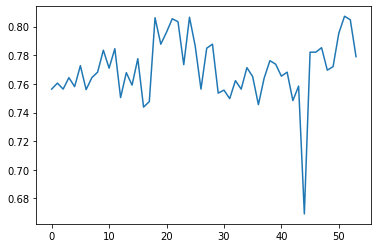

In [590]:
import matplotlib.pyplot as plt

index=resultats.index(max(resultats))
print (resultats[index],params[index])
# My Model
mySGDClassifier = calcul_score_fin(params[index])
mySGDClassifier.score(X_test,y_test)

plt.plot(resultats)

# 0.8079470198675497

# Modelling
Now let's apply Grid search on both of these to get the best parameteres

In [591]:

LGBM_grid = {'n_estimators': [160, 170, 180],
        'max_depth': [8],
        'learning_rate': [0.05, 0.06]}

In [592]:
LGBM_clf=GridSearchCV(estimator=LGBMClassifier(),param_grid=LGBM_grid,n_jobs=1,cv=5,verbose=True)

In [593]:
#sf = SequentialFeatureSelector(LGBM_clf, scoring='accuracy', direction = 'backward')
#sf.fit(X_train,y_train)

#best_features = list(sf.get_feature_names_out())
#best_features

In [594]:
#Fit the model
LGBM_clf.fit(X_train,y_train)

#Score of the model
print(LGBM_clf.score(X_test,y_test))

LGBM_clf.best_estimator_
# 0.8184036249564308

Fitting 5 folds for each of 6 candidates, totalling 30 fits
0.8184036249564308


LGBMClassifier(learning_rate=0.05, max_depth=8, n_estimators=170)

# Submission

In [595]:
pred=LGBM_clf.predict(test_send)

In [596]:
output = pd.DataFrame({'PassengerId': test.PassengerId, 'Transported': pred})
output.to_csv('submission.csv', index=False)
print("Predictions Saved")

Predictions Saved


# ---------------------------------------------------------------------------------------------------------------------------------
# ---------------------------------------------------------------------------------------------------------------------------------

Notes:

    1. PassengerID takes the form of gggg_pp where gggg indicated the group a passenger belongs to and pp indicates the no within the group
    
    2. The cabin has a format of Deck/Num/Side
    
    
Inference:
    
    1.We can extract group and groupsize from PassengerId
    
    2.We can extract deck and side from Cabin
    
    3. Sirname can be used to identify families

Notes:

    1. The most Home Planet among the passengers is Earth, however we can't use it to fill the missing values as the no of poeple from europa and mars is significant
    
    2. The most common destination among the passengers is TRAPPIST-1e where about 69.5% of the people are going
    
    3. Most of the passengers (97.5%) are not VIPs but the target split is more or less the same i.e. 50% transported and 50% not in either categiry
    
    4. Only 35.8% of the people opted for cryosleep
    
Inference:

     1.VIP column can be dropped to avoid overfitting 
    
    

**Age status**

Bin age feature into groups. This will be helpful for filling missing values like expenditure according to age.